<h2> Imports </h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Cropping1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

<h2> Load Data</h2>

In [3]:
# Load the datasets
normal_df = pd.read_csv("ptdb-dataset/ptbdb_normal.csv", header=None)
abnormal_df = pd.read_csv("ptdb-dataset/ptbdb_abnormal.csv", header=None)

# Print shapes
print(f"Normal shape: {normal_df.shape}")
print(f"Abnormal shape: {abnormal_df.shape}")

# Combine for EDA
combined_df = pd.concat([normal_df, abnormal_df], axis=0).reset_index(drop=True)
combined_df.rename(columns={combined_df.columns[-1]: 'label'}, inplace=True) # rename last column as label

#normal 0
#abnormal 1

# Preview
display(combined_df.head())
combined_df.to_csv('combined_df.csv')

Normal shape: (4046, 188)
Abnormal shape: (10506, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2> Class Distribution</h2>

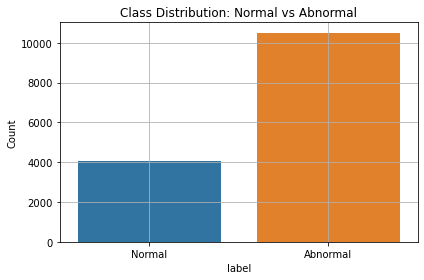

In [4]:
# Count plot showing the number of samples per class (Normal vs Abnormal)
sns.countplot(x='label', data=combined_df)
plt.title("Class Distribution: Normal vs Abnormal")
plt.xticks([0, 1], ['Normal', 'Abnormal'])
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

<h2> Plot normal and abnormal ECGs</h2>

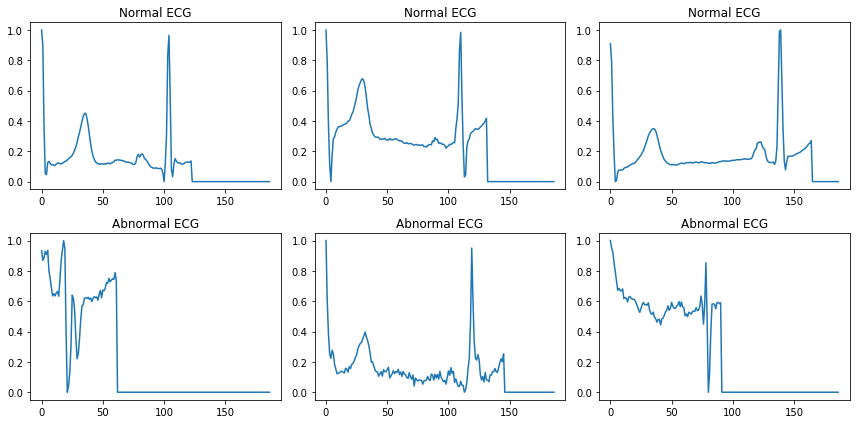

In [5]:
# Plot the first 3 normal and abnormal ECG signals

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.plot(normal_df.iloc[i, :-1])
    plt.title("Normal ECG")

for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.plot(abnormal_df.iloc[i, :-1])
    plt.title("Abnormal ECG")

plt.tight_layout()
plt.show()

- Normal ECGs tend to have more regular, periodic patterns

- Abnormal ECGs show more irregular waveforms and artifacts

<h2> Check for missing value</h2>

In [6]:
print("Missing values:", combined_df.isnull().sum().sum())
print("Any NaNs?", combined_df.isna().any().any())

Missing values: 0
Any NaNs? False


<h2> Correlation heatmap </h2>

- Red indicates a positive correlation (values close to +1.0)

- Blue indicates a negative correlation (values close to -1.0)

- White indicates a weak or no correlation (values close to 0)

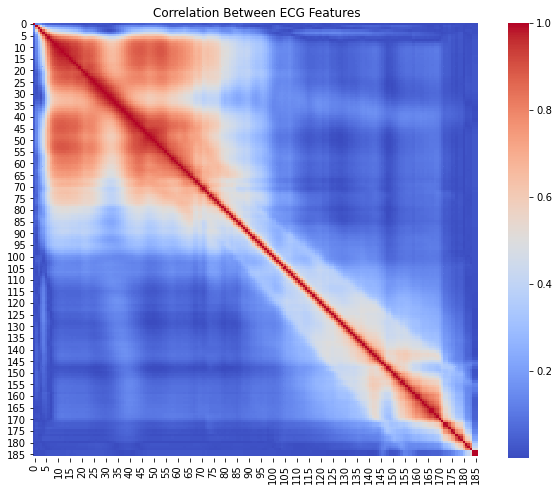

In [7]:
# Plot the heatmap of feature correlations using a coolwarm color map

corr = combined_df.iloc[:, :-1].corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', cbar=True)
plt.title("Correlation Between ECG Features")
plt.show()

- Highly correlated features (red zones): Many of the features carry overlapping or redundant information.

- Weakly correlated (blue zones): Features behave more independently.


<h2> Check all signals are the same length. </h2>

- If not, they need padding or trimming.

In [8]:
print("Signal length (features):", normal_df.shape[1] - 1)

Signal length (features): 187


<h2> Plot multiple ECGs from both normal and abnormal sets to see the variation.

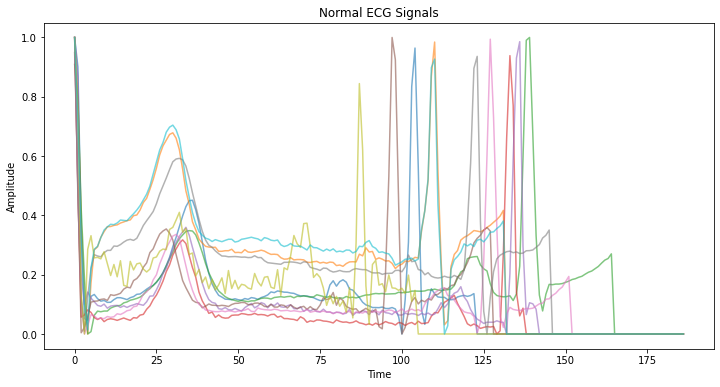

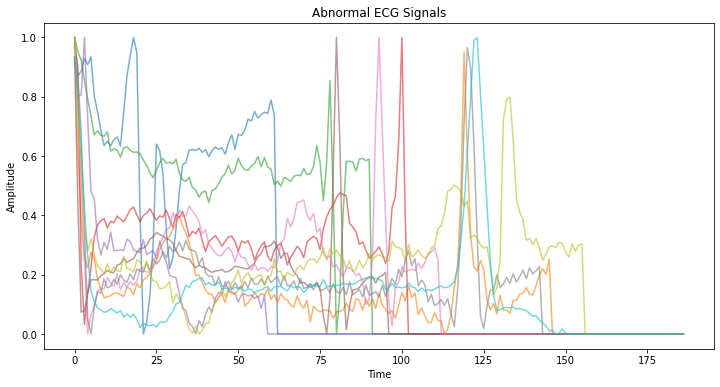

In [9]:
# Define a function to plot multiple ECG signals from a DataFrame
def plot_multiple_signals(df, label, title, n=10):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.plot(df.iloc[i, :-1], label=f"{label} {i+1}", alpha=0.6)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

plot_multiple_signals(normal_df, 'Normal', 'Normal ECG Signals')
plot_multiple_signals(abnormal_df, 'Abnormal', 'Abnormal ECG Signals')

<h1> Visualization

- The plots (e.g., signal entropy, average value, PCA visualization) help to see how normal and abnormal signals differ in terms of their statistical properties.

- This helps answer: Are anomalies more random? Do they have higher energy? Do they cluster differently?

We need these plots and EDA to: 

- Understand the data
- Choose appropriate models
- Improve feature engineering
- Interpret results

## 1. Signal value comparison
- Detect if abnormal cases tend to have higher/lower overall signal levels.

- See if the two groups are separable based on mean signal strength.

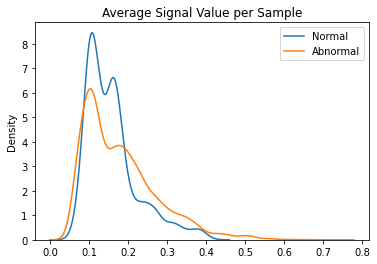

In [10]:
# Plot the KDE (smoothed histogram) of average values for normal and abnormal samples
normal_stats = normal_df.iloc[:, :-1].mean(axis=1)
abnormal_stats = abnormal_df.iloc[:, :-1].mean(axis=1)

plt.figure(figsize=(6,4))
sns.kdeplot(normal_stats, label='Normal')
sns.kdeplot(abnormal_stats, label='Abnormal')
plt.title('Average Signal Value per Sample')
plt.legend()
plt.show()

- It compares how the average signal value differs between normal and abnormal ECGs.

- It is seen that normal ECGs (blue) tend to have a higher peak density in a lower average value range (around 0.1–0.15), meaning most normal ECGs have consistent, low-amplitude signals.

- Abnormal ECGs (orange) are more spread out and have a wider range of average values, showing more variability and unusual activity.

Why it’s needed:
- This helps us understand if abnormal heart signals consistently have different overall signal strengths compared to normal ones. It’s a basic statistical signal comparison to detect early patterns or trends between the two classes.

## 2. Energy shows how intense the signal is using sum of squares

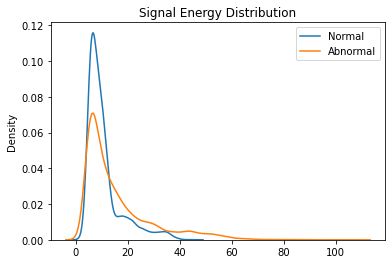

In [11]:
# Plot the KDE (smoothed histogram) of signal energy for normal and abnormal samples
normal_energy = (normal_df.iloc[:, :-1]**2).sum(axis=1)
abnormal_energy = (abnormal_df.iloc[:, :-1]**2).sum(axis=1)

plt.figure(figsize=(6, 4))
sns.kdeplot(normal_energy, label='Normal')
sns.kdeplot(abnormal_energy, label='Abnormal')
plt.title("Signal Energy Distribution")
plt.legend()
plt.show()

- Signal energy reflects the strength or intensity of the signal.

- Normal ECGs (blue) mostly have lower energy, while abnormal ECGs (orange) have broader and higher energy values, indicating stronger or more erratic signals.

- The wider spread of the orange line means abnormal ECGs can be more energetic and variable, which could point to heart irregularities.

- There is significant overlap between the two distributions, particularly around the lower Signal Energy values

Why it’s needed:
- Abnormal heart activity often results in stronger or erratic electrical signals, which this energy measure can help capture. By comparing this, we can potentially use energy as a feature to differentiate between healthy and unhealthy ECGs.

## 3. Signal variability (Standard Deviation)

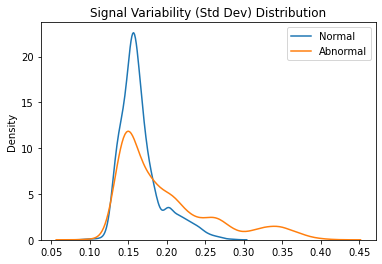

In [12]:
# Plot the KDE (smoothed histogram) of signal variability for normal and abnormal samples
normal_std = normal_df.iloc[:, :-1].std(axis=1)
abnormal_std = abnormal_df.iloc[:, :-1].std(axis=1)

plt.figure(figsize=(6, 4))
sns.kdeplot(normal_std, label='Normal')
sns.kdeplot(abnormal_std, label='Abnormal')
plt.title("Signal Variability (Std Dev) Distribution")
plt.legend()
plt.show()

- It refers to the standard deviation (std) of the ECG signal values across each sample.

- Standard deviation captures how much the signal fluctuates → higher std = more variability/spikes.

- Normal signals (blue): Have lower standard deviation centered around ~0.15. Very narrow peak, indicating consistency (low variability).  Suggests that normal heartbeats are rhythmically stable and produce consistent signal patterns.

- Abnormal signals (orange): Show wider spread of standard deviation values. The peak is lower and shifted slightly right. This means abnormal ECGs have more variable signals — they might spike or fluctuate more than normal.

## 4. Entropy shows how chaotic a signal is

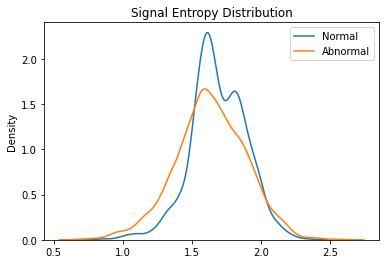

In [13]:
# Plot the KDE (smoothed histogram) of signal entropy for normal samples

normal_entropy = normal_df.iloc[:, :-1].apply(lambda x: entropy(np.histogram(x, bins=20)[0]), axis=1)
abnormal_entropy = abnormal_df.iloc[:, :-1].apply(lambda x: entropy(np.histogram(x, bins=20)[0]), axis=1)

plt.figure(figsize=(6,4))
sns.kdeplot(normal_entropy, label='Normal')
sns.kdeplot(abnormal_entropy, label='Abnormal')
plt.title("Signal Entropy Distribution")
plt.legend()
plt.show()

- Entropy is a measure of randomness, irregularity, or unpredictability in a signal. 
- In ECGs, Low entropy indicates more regular, predictable waveforms (typical of healthy heartbeats). 
- High entropy indicates more chaotic, irregular patterns (often found in arrhythmias or other cardiac anomalies) 
- Normal signals (blue): Peak around 1.6–1.7. Narrower distribution → more consistent across patients. Indicates low-to-moderate entropy and stable ECG rhythms. 
- Abnormal signals (orange): Also peak near 1.6, but more spread out Flatter, wider shape Greater tail toward both lower and higher entropy

## PCA 

- To see if normal and abnormal heartbeats separate in lower dimensions

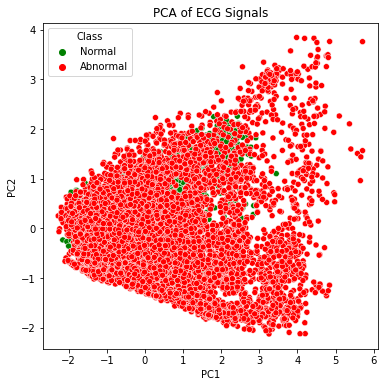

In [14]:
X = combined_df.iloc[:, :-1] # All columns except the last one (features only)
y = combined_df.iloc[:, -1]   # Last column contains labels

# Apply PCA to reduce features to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

combined_df['class_name'] = combined_df['label'].map({0: 'Normal', 1: 'Abnormal'})

# Create a scatter plot of the PCA-transformed data, colored by class
plt.figure(figsize=(6,6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=combined_df['class_name'],
    palette={'Normal': 'green', 'Abnormal': 'red'}
)

plt.title('PCA of ECG Signals')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Class')
plt.show()

- The green dots are relatively sparse and scattered across the plot.
They appear to be more concentrated toward the lower-left region of the plot, particularly around the origin (0, 0).
There are fewer green dots compared to red dots, indicating that normal signals are less frequent or fewer in number in this dataset.

- The red dots are much more numerous and densely clustered.
They occupy a larger area of the plot, extending from the lower-left to the upper-right regions.
The red dots show significant overlap with the green dots, especially near the origin.

- There is substantial overlap between the green and red dots, particularly around the origin and along certain regions of the plot. This indicates that PCA alone may not provide a clear separation between normal and abnormal signals based on these two principal components.


<h1> Pre-processing </h1>

<h2> Data Normalization/Standardization </h2>

- ECG signals are typically noisy , so normalization is essential.

- Min-Max Scaling : Scale all signal values to a fixed range (e.g., [0, 1])

In [15]:
# Separate features and labels
# Feed the raw ECG signal into the model not the labels
X_normal = normal_df.iloc[:, :-1].values
X_abnormal = abnormal_df.iloc[:, :-1].values

# Scales all ECG signal values to a range of 0 to 1.
# Neural networks work better when input values are in the same range; it speeds up training and improves accuracy.
scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_abnormal_scaled = scaler.transform(X_abnormal)
print("Normal shape:", X_normal.shape)
print("After scaling:", X_normal_scaled.shape)

# Reshape for Conv1D input: (samples, time_steps, channels)
# 1D convolution layers expect data in this format; this represents 187 ECG points per sample with 1 channel 
X_normal_scaled = X_normal_scaled.reshape((-1, 187, 1))
X_abnormal_scaled = X_abnormal_scaled.reshape((-1, 187, 1))

# Split normal ECGs for training/validation
X_train, X_val = train_test_split(X_normal_scaled, test_size=0.2, random_state=42)


Normal shape: (4046, 187)
After scaling: (4046, 187)


# Define Autoencoder Model

- Autoencoders learn a compressed representation of normal patterns .
- During inference, they will be used to reconstruct both normal and abnormal signals.
- Abnormal signals will have higher reconstruction error , which can threshold to detect anomalies.

In [16]:
# Autoencoder = Encoder + Decoder

input_shape = (187, 1)
inputs = Input(shape=input_shape)

# Encoder: compresses signal
x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

# Decoder: reconstructs signal
x = Conv1D(16, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)

# Output now is 188 — so crop 1 timestep
x = Cropping1D(cropping=(0, 1))(x)

decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)

# Build model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 187, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 94, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 47, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 47, 16)            784   

What it does:

- The encoder compresses the input signal to a smaller representation.

- The decoder tries to reconstruct the original signal from that compressed version.

Why needed:

- By training only on normal signals, the autoencoder learns the normal pattern.

- Later, when give it an abnormal signal, it will struggle to reconstruct it well, leading to a higher error — that’s how detect abnormalities!

What is a 1D Convolution Network?
- A 1D Convolutional Neural Network (1D CNN) applies convolution across one dimension, usually time. In this case:

- ECG signals are time-series data with 187 time steps and 1 channel.

- Each sample is like a heartbeat waveform.

<h2> Train the Autoencoder

In [17]:
# Trains the model to reconstruct normal ECGs. The model learns what a normal ECG should look like.
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(X_val, X_val)
)

Epoch 1/50
51/51 [==============================] - 3s 31ms/step - loss: 0.0817 - val_loss: 0.0256
Epoch 2/50
51/51 [==============================] - 1s 25ms/step - loss: 0.0102 - val_loss: 0.0051
Epoch 3/50
51/51 [==============================] - 1s 26ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/50
51/51 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/50
51/51 [==============================] - 1s 25ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
51/51 [==============================] - 1s 23ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
51/51 [==============================] - 1s 23ms/step - loss: 9.8370e-04 - val_loss: 9.8302e-04
Epoch 8/50
51/51 [==============================] - 1s 24ms/step - loss: 8.9973e-04 - val_loss: 9.0972e-04
Epoch 9/50
51/51 [==============================] - 1s 23ms/step - loss: 8.3195e-04 - val_loss: 8.4734e-04
Epoch 10/50
51/51 [==============================] - 1s 23ms/step - loss: 7.7443e-04 

### Save the autoencoder

In [18]:
# Save the model
autoencoder.save("ecg_autoencoder_model.h5")

## Predict Normal & Abnormal Reconstructions

In [19]:
# Reconstructs both normal and abnormal signals using the trained autoencoder. 
# Helps to compare how well the autoencoder reconstructs each type.

recon_normal = autoencoder.predict(X_normal_scaled)
recon_abnormal = autoencoder.predict(X_abnormal_scaled)

329/329 [==============================] - 2s 5ms/step


## Calculate Reconstruction Errors

In [20]:
# Use Mean Absolute reconstruction error for each sample
errors_normal = np.mean(np.abs(X_normal_scaled - recon_normal), axis=(1, 2))
errors_abnormal = np.mean(np.abs(X_abnormal_scaled - recon_abnormal), axis=(1, 2))

- Reconstruction Error is the difference between the original ECG signal and the reconstructed one produced by the autoencoder.

- For normal signals: Error should be small → the model knows how to reconstruct them.

- For abnormal signals: Error should be large → the model has never seen such patterns and struggles to reconstruct them correctly.

## Visualize Error Distributions

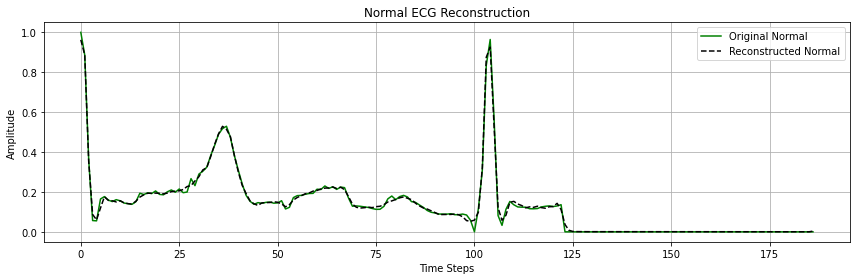

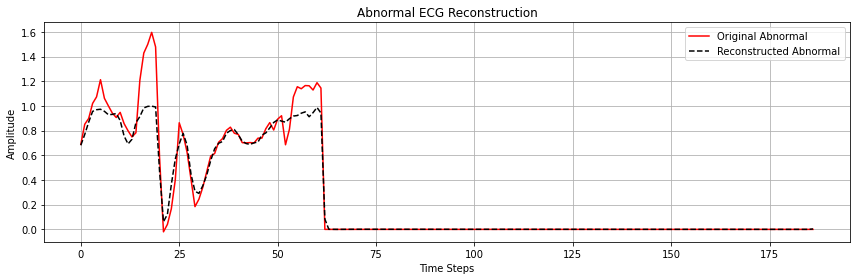

In [21]:
# Choose one sample from each
idx_normal = 0
idx_abnormal = 0

# Extract and squeeze the original and reconstructed samples
original_normal = X_normal_scaled[idx_normal].squeeze()
reconstructed_normal = recon_normal[idx_normal].squeeze()

original_abnormal = X_abnormal_scaled[idx_abnormal].squeeze()
reconstructed_abnormal = recon_abnormal[idx_abnormal].squeeze()

# Plot Normal ECG
plt.figure(figsize=(12, 4))
plt.plot(original_normal, label='Original Normal', color='green')
plt.plot(reconstructed_normal, label='Reconstructed Normal', linestyle='--', color='black')
plt.title('Normal ECG Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Abnormal ECG
plt.figure(figsize=(12, 4))
plt.plot(original_abnormal, label='Original Abnormal', color='red')
plt.plot(reconstructed_abnormal, label='Reconstructed Abnormal', linestyle='--', color='black')
plt.title('Abnormal ECG Reconstruction')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1. Normal ECG (Top Plot)
- Original (Solid Green): Clear R-peaks, consistent waveform structure.

- Reconstructed (Dashed Green): Closely matches the original with minor deviations.

- Insight: Autoencoder accurately captures normal ECG patterns, indicating strong learning of typical cardiac behavior.

2. Abnormal ECG (Bottom Plot)

- Original (Solid Red): Irregular waveform, erratic peaks, and structural inconsistencies.

- Reconstructed (Dashed Red): Fails to replicate abnormalities; output appears overly smoothed.

- Insight: The model struggles with unseen abnormal signals, showing poor reconstruction.

3. Key Takeaway

- Normal signals → Low reconstruction error

- Abnormal signals → High reconstruction error

- Conclusion: Reconstruction error serves as a reliable metric for anomaly detection in ECG data.

## Set a threshold to flag anomalies

In [22]:
# Sets a cutoff value of the 95th percentile of normal errors.
# Anything above this threshold is treated as abnormal.

threshold = np.percentile(errors_normal, 95)

## Classify samples using the threshold

In [23]:
# Predict labels based on threshold
y_pred = np.concatenate([
    (errors_normal > threshold).astype(int),
    (errors_abnormal > threshold).astype(int)
])

# True labels
y_true = np.concatenate([
    np.zeros_like(errors_normal),    # Normal = 0
    np.ones_like(errors_abnormal)    # Abnormal = 1
])


## Visualize Normal vs Abnormal ECG Reconstruction

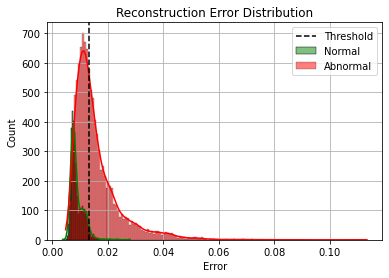

In [24]:
# Plot the distribution of reconstruction errors with KDE
sns.histplot(errors_normal, color='green', label='Normal', kde=True)
sns.histplot(errors_abnormal, color='red', label='Abnormal', kde=True)
plt.axvline(np.percentile(errors_normal, 95), color='black', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.legend()
plt.grid()
plt.show()


## Evaluate Anomaly Detector with threshold

In [25]:
print("\nClassification Report - Autoencoder + threshold:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"]))


Classification Report - Autoencoder + threshold:
              precision    recall  f1-score   support

      Normal       0.43      0.95      0.59      4046
    Abnormal       0.96      0.51      0.67     10506

    accuracy                           0.63     14552
   macro avg       0.70      0.73      0.63     14552
weighted avg       0.81      0.63      0.65     14552



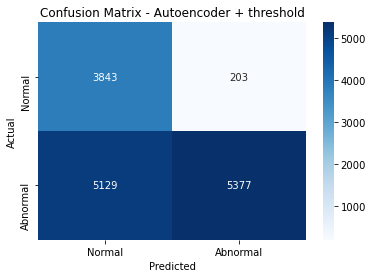

In [26]:
# Plot Confusion Matrix for Autoencoder + threshold
cm1 = confusion_matrix(y_true, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - Autoencoder + threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The current pipeline:


* Trains the autoencoder only on normal ECGs (good for SSL)
* Uses reconstruction error to detect anomalies
* Chooses a static threshold (e.g. 95th percentile of normal errors)


But this:


* May not distinguish all anomalies well
* May misclassify many abnormal cases as normal (high false negatives)


# Improvement 1: Tune the Threshold
Instead of hardcoding 95th percentile:
- Youden’s J maximizes the difference between TPR and FPR.
- Helps find a more optimal threshold.
- Great for imbalanced datasets.

- True Positive Rate (TPR) = How many actual positives are correctly detected.

- False Positive Rate (FPR) = How many actual negatives are incorrectly predicted as positive.

- So maximizing Youden’s J gives the threshold where the model performs best in balancing sensitivity and specificity, especially important for imbalanced data like anomaly detection (normal ≫ abnormal).

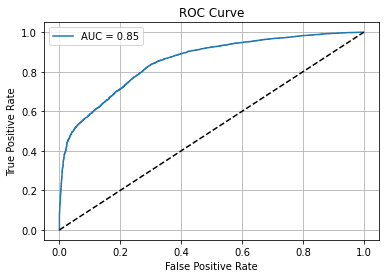

In [27]:
# Combine normal and abnormal error scores into a single array
all_errors = np.concatenate([errors_normal, errors_abnormal])

# Create corresponding labels: 0 for normal, 1 for abnormal
all_labels = np.concatenate([np.zeros_like(errors_normal), np.ones_like(errors_abnormal)])

# Compute False Positive Rate, True Positive Rate, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_errors)

# Calculate the Area Under the Curve (AUC) for the ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve with AUC value in the legend
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Compute Youden's J
youden_j = tpr - fpr

# Find index of max J
best_index = np.argmax(youden_j)
best_threshold = thresholds[best_index]

print(f"Best threshold based on Youden's J: {best_threshold:.4f}")

Best threshold based on Youden's J: 0.0094


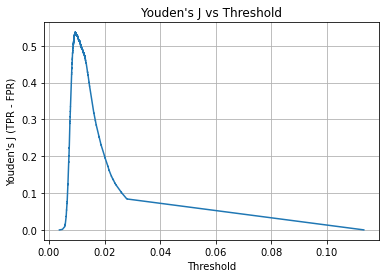

In [29]:
# Plot Youden's J statistic against ROC-derived thresholds
plt.plot(thresholds, youden_j)
plt.xlabel("Threshold")
plt.ylabel("Youden's J (TPR - FPR)")
plt.title("Youden's J vs Threshold")
plt.grid()
plt.show()

In [30]:
# Predict using new threshold
y_pred2 = np.concatenate([
    (errors_normal > best_threshold).astype(int),
    (errors_abnormal > best_threshold).astype(int)
])


In [31]:
print("\nClassification Report - Autoencoder + Youden's threshold:")
print(classification_report(y_true, y_pred2, target_names=["Normal", "Abnormal"]))


Classification Report - Autoencoder + Youden's threshold:
              precision    recall  f1-score   support

      Normal       0.62      0.70      0.66      4046
    Abnormal       0.88      0.84      0.86     10506

    accuracy                           0.80     14552
   macro avg       0.75      0.77      0.76     14552
weighted avg       0.81      0.80      0.80     14552



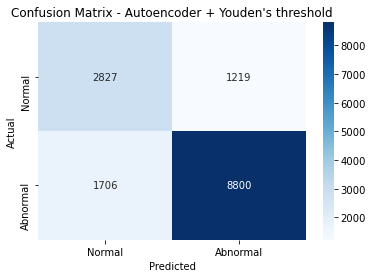

In [32]:
# Plot confusion matrix - Autoencoder + Youden's threshold
cm2 = confusion_matrix(y_true, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - Autoencoder + Youden's threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Improvement 2: Different Error Metrics

In [33]:
# Calculate the maximum absolute reconstruction error for each sample
errors_normal_mae = np.max(np.abs(X_normal_scaled - recon_normal), axis=(1, 2))
errors_abnormal_mae = np.max(np.abs(X_abnormal_scaled - recon_abnormal), axis=(1, 2))
print("errors_normal",errors_normal_mae)
print("errors_abnormal",errors_abnormal_mae)

errors_normal [0.0587074  0.09217305 0.07985406 ... 0.12697937 0.08712643 0.07679805]
errors_abnormal [0.59774481 0.13942835 0.13227306 ... 0.08549291 0.13065559 0.09279519]


- Uses maximum absolute error per sample instead of mean.
- Detects sharp deviations in any part of the ECG.

Why needed:

- Captures local anomalies better.
- Mean error could hide short bursts of abnormality.

In [34]:
# Combine errors
all_errors_mae = np.concatenate([errors_normal_mae, errors_abnormal_mae])

# Create true labels: 0 for normal, 1 for abnormal
all_labels_mae = np.concatenate([
    np.zeros_like(errors_normal_mae),    # Label 0
    np.ones_like(errors_abnormal_mae)    # Label 1
])

In [35]:
# Calculate ROC curve
fpr_mae, tpr_mae, thresholds_mae = roc_curve(all_labels_mae, all_errors_mae)
roc_auc_mae = auc(fpr_mae, tpr_mae)

# Use Youden’s J statistic to find best threshold using Maximum Absolute Error
youden_j_mae = tpr_mae - fpr_mae
best_index_mae = np.argmax(youden_j_mae)
best_threshold_mae = thresholds_mae[best_index_mae]

print(f"Best threshold from Youden’s J using Maximum Absolute Error: {best_threshold_mae:.4f}")

Best threshold from Youden’s J using Maximum Absolute Error: 0.1189


In [36]:
# Predict labels based on best threshold
y_pred3 = (all_errors_mae > best_threshold_mae).astype(int)

In [37]:
print("\nClassification Report - Autoencoder + Max AE:")
print(classification_report(y_true, y_pred3, target_names=["Normal", "Abnormal"]))


Classification Report - Autoencoder + Max AE:
              precision    recall  f1-score   support

      Normal       0.44      0.86      0.59      4046
    Abnormal       0.92      0.58      0.71     10506

    accuracy                           0.66     14552
   macro avg       0.68      0.72      0.65     14552
weighted avg       0.79      0.66      0.68     14552



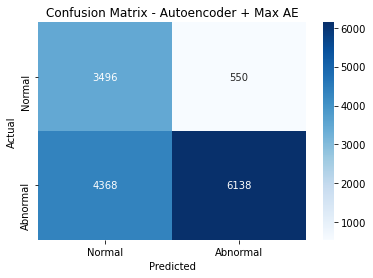

In [38]:
# Plot confusion matrix for Autoencoder + Max Absolute Error
cm3 = confusion_matrix(y_true, y_pred3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - Autoencoder + Max AE")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Improvement 3: Use a Classifier on Encoder Features (Hybrid Approach)

In [39]:
# Encoder = model from input to bottleneck (encoded output)
# Extracts bottleneck features (compressed representation of ECG).
# These are like learned features for how normal ECGs should look.

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=4).output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 187, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 94, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 47, 16)           0         
 1D)                                                             
                                                                 
Total params: 1,680
Trainable params: 1,680
Non-trainable p

In [40]:
# Save encoder
# joblib.dump(encoder, "encoder.pkl")
encoder.save("encoder_model.h5")  

In [41]:
# Get encoded features
encoded_normal = encoder.predict(X_normal_scaled)
encoded_abnormal = encoder.predict(X_abnormal_scaled)

# Flatten for classifier input
X_encoded_all = np.concatenate([
    encoded_normal.reshape(encoded_normal.shape[0], -1),
    encoded_abnormal.reshape(encoded_abnormal.shape[0], -1)
])

y_encoded_all = np.concatenate([
    np.zeros(encoded_normal.shape[0]),  # normal = 0
    np.ones(encoded_abnormal.shape[0])  # abnormal = 1
])


329/329 [==============================] - 1s 3ms/step


In [42]:
# Split into training and testing sets
# stratify makes sure to keep the same class ratio in both sets.

X_train, X_test, y_train, y_test= train_test_split(
    X_encoded_all, y_encoded_all, test_size=0.2, random_state=42, stratify=y_encoded_all
)

## 1. Random Forest

In [43]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Classifier is now explicitly learning to distinguish normal vs abnormal using learned features
clf.fit(X_train, y_train)

# Predict
y_pred_clf = clf.predict(X_test)

In [44]:
# Calculate the train and test accuracy score for RF
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f"Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")

Train Score: 1.0000, Test Score: 0.9780


In [45]:
# Classification Report for RF
print("\nClassification Report - Hybrid Classifier - RF:")
print(classification_report(y_test, y_pred_clf, target_names=["Normal", "Abnormal"]))


Classification Report - Hybrid Classifier - RF:
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96       809
    Abnormal       0.98      0.99      0.98      2102

    accuracy                           0.98      2911
   macro avg       0.98      0.97      0.97      2911
weighted avg       0.98      0.98      0.98      2911



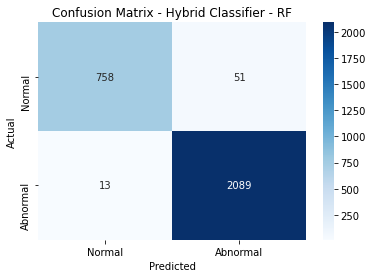

In [46]:
# Plot Confusion Matrix for Hybrid Classifier with RF
cm4 = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - Hybrid Classifier - RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- Too powerful model (RandomForest) on small dataset.

- Latent features may be very easy to separate, leading to high accuracy but poor generalization.

- No regularization or feature selection is applied.

## 2. MLP

In [47]:
# Define a simple MLP model
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_encoded_all.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and binary cross-entropy loss
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on training data with validation split
mlp.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, shuffle=False)

# Predict on test data and convert probabilities to binary labels
y_pred_mlp = (mlp.predict(X_test) > 0.5).astype(int)

Epoch 1/20
146/146 [==============================] - 1s 3ms/step - loss: 0.4556 - accuracy: 0.7697 - val_loss: 0.3905 - val_accuracy: 0.8055
Epoch 2/20
146/146 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.8126 - val_loss: 0.3647 - val_accuracy: 0.8257
Epoch 3/20
146/146 [==============================] - 0s 2ms/step - loss: 0.3650 - accuracy: 0.8272 - val_loss: 0.3498 - val_accuracy: 0.8377
Epoch 4/20
146/146 [==============================] - 0s 2ms/step - loss: 0.3499 - accuracy: 0.8380 - val_loss: 0.3352 - val_accuracy: 0.8527
Epoch 5/20
146/146 [==============================] - 0s 2ms/step - loss: 0.3322 - accuracy: 0.8471 - val_loss: 0.3185 - val_accuracy: 0.8592
Epoch 6/20
146/146 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.8573 - val_loss: 0.3124 - val_accuracy: 0.8622
Epoch 7/20
146/146 [==============================] - 0s 2ms/step - loss: 0.3005 - accuracy: 0.8642 - val_loss: 0.2966 - val_accuracy: 0.8733
Epoch 

In [48]:
# Evaluate the MLP model on training data and get loss and accuracy
train_loss_mlp, train_accuracy_mlp = mlp.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy_mlp:.4f}")

# Evaluate the MLP model on test data and get loss and accuracy
test_loss_mlp, test_accuracy_mlp = mlp.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy_mlp:.4f}")

Train Accuracy: 0.9432
Test Accuracy: 0.9320


In [49]:
# Print classification report for MLP predictions on test data

print("\nClassification Report - Hybrid Classifier - MLP:")
print(classification_report(y_test, y_pred_mlp, target_names=["Normal", "Abnormal"]))


Classification Report - Hybrid Classifier - MLP:
              precision    recall  f1-score   support

      Normal       0.85      0.91      0.88       809
    Abnormal       0.97      0.94      0.95      2102

    accuracy                           0.93      2911
   macro avg       0.91      0.93      0.92      2911
weighted avg       0.93      0.93      0.93      2911



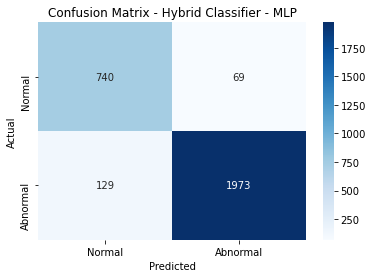

In [50]:
# Plot Confusion Matrix for Hybrid Classifier with MLP
cm5 = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - Hybrid Classifier - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 3. Logistic Regression

In [51]:
# Initialize a Logistic Regression model with L2 regularization
lr = LogisticRegression(penalty='l2', max_iter=1000, random_state=42)

# Train the logistic regression model on training data
lr.fit(X_train, y_train)

# Predict labels on test data using logistic regression
y_pred_lr = lr.predict(X_test)

In [52]:
# Calculate and print training and test accuracy scores for logistic regression

train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
print(f"Train Score LR: {train_score_lr:.4f}, Test Score: {test_score_lr:.4f}")

Train Score LR: 0.9219, Test Score: 0.9090


In [53]:
# Print classification report for Logistic Regression predictions on test data

print("\nClassification Report - Hybrid Classifier - LR:")
print(classification_report(y_test, y_pred_lr, target_names=["Normal", "Abnormal"]))


Classification Report - Hybrid Classifier - LR:
              precision    recall  f1-score   support

      Normal       0.86      0.80      0.83       809
    Abnormal       0.93      0.95      0.94      2102

    accuracy                           0.91      2911
   macro avg       0.89      0.88      0.88      2911
weighted avg       0.91      0.91      0.91      2911



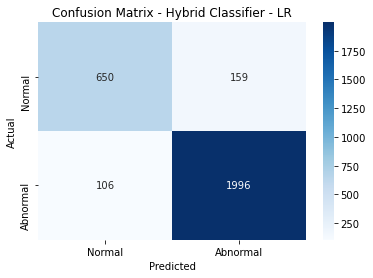

In [54]:
# Plot Confusion Matrix for Hybrid Classifier with LR

cm6 = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm6, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - Hybrid Classifier - LR")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- The high scores may be valid due to the use of expressive encoded features, a powerful Random Forest classifier, and a class distribution favoring abnormal samples (~10k vs ~4k), giving the model plenty of examples. 

- However, results could be inflated by potential issues such as data leakage (if features were extracted before splitting), lack of stratified sampling, overfitting due to limited validation, and the use of a clean, synthetic dataset without real-world noise or edge cases.

## 4. Use Cross-Validation and Reduce complexity of the RF classifier

- max_depth=5 restricts the tree depth.

- This reduces memorization

In [55]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Param grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# RF Classifier
rf = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit using TRAINING data only
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [56]:
# Save best model
joblib.dump({
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
    'model': grid_search.best_estimator_
}, "tuned_random_forest.pkl")

['tuned_random_forest.pkl']

In [57]:
# Load saved model
saved_data = joblib.load("tuned_random_forest.pkl")
best_rf = saved_data['model']

In [58]:
print("Loaded Parameters:", saved_data['best_params'])
print("Loaded CV Score:", saved_data['best_score'])

# Predict on TEST set
y_pred_best_rf = best_rf.predict(X_test)

Loaded Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Loaded CV Score: 0.9830483157509009


In [59]:
# Print training and test accuracy scores

train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print(f"Train Score RF (Tuned): {train_score:.4f}, Test Score: {test_score:.4f}")

Train Score RF (Tuned): 0.9993, Test Score: 0.9763


In [60]:
# Print classification report for the tuned RF classifier

print("\nClassification Report - RF (Tuned):")
print(classification_report(y_test, y_pred_best_rf, target_names=["Normal", "Abnormal"]))


Classification Report - RF (Tuned):
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.96       809
    Abnormal       0.98      0.99      0.98      2102

    accuracy                           0.98      2911
   macro avg       0.98      0.96      0.97      2911
weighted avg       0.98      0.98      0.98      2911



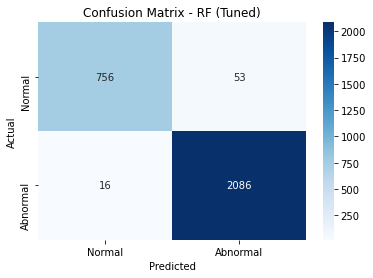

In [61]:
# Compute and plot the confusion matrix
cm_rf_tuned = confusion_matrix(y_test, y_pred_best_rf)
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Abnormal'],
            yticklabels=['Normal','Abnormal'])
plt.title("Confusion Matrix - RF (Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Evaluation comparison table

In [63]:
# Calculate precision, recall, and F1 score for Autoencoder-based method
f1_auto = f1_score(y_true, y_pred)
precision_auto = precision_score(y_true, y_pred)
recall_auto = recall_score(y_true, y_pred)

# Calculate metrics for Hybrid Classifier - RF
f1_clf = f1_score(y_test, y_pred_clf)
precision_clf = precision_score(y_test, y_pred_clf)
recall_clf = recall_score(y_test, y_pred_clf)

# Calculate metrics for Hybrid Classifier - MLP
f1_mlp = f1_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)

# Calculate metrics for Hybrid Classifier - Logistic Regression
f1_lr = f1_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)

# Calculate metrics for Hybrid Classifier - Tuned 
f1_clf_best_rf = f1_score(y_test, y_pred_best_rf)
precision_clf_best_rf = precision_score(y_test, y_pred_best_rf)
recall_clf_best_rf = recall_score(y_test, y_pred_best_rf)


# Print performance comparison of all models
print("Performance Comparison:\n")
print(f"{'Method':<35}{'Precision':<12}{'Recall':<10}{'F1 Score'}")
print(f"{'Autoencoder (Threshold)':<35}{precision_auto:<12.4f}{recall_auto:<10.4f}{f1_auto:.4f}")
print(f"{'Hybrid (Classifier) RF':<35}{precision_clf:<12.4f}{recall_clf:<10.4f}{f1_clf:.4f}")
print(f"{'Hybrid (Classifier) MLP':<35}{precision_mlp:<12.4f}{recall_mlp:<10.4f}{f1_mlp:.4f}")
print(f"{'Hybrid (Classifier) LR':<35}{precision_lr:<12.4f}{recall_lr:<10.4f}{f1_lr:.4f}")
print(f"{'Hybrid Classifier RF with tuning':<35}{precision_clf_best_rf:<12.4f}{recall_clf_best_rf:<10.4f}{f1_clf_best_rf:.4f}")


Performance Comparison:

Method                             Precision   Recall    F1 Score
Autoencoder (Threshold)            0.9636      0.5118    0.6685
Hybrid (Classifier) RF             0.9762      0.9938    0.9849
Hybrid (Classifier) MLP            0.9662      0.9386    0.9522
Hybrid (Classifier) LR             0.9262      0.9496    0.9377
Hybrid Classifier RF with tuning   0.9752      0.9924    0.9837


- Untuned RF had perfect training accuracy, which is a red flag for overfitting → meaning it memorized the training data and might fail on unseen cases.

- Tuned RF gives slightly lower performance but is more reliable and generalizable.

- In medical anomaly detection (like ECG), generalization is crucial →  It should work on new patient data, not just what it saw during training.

- Slightly lower precision/recall is acceptable if the model avoids false confidence from overfitting.

***End***